# Entrenamiento del Modelo para deteccion de anomalias

Este notebook esta enfocado en realizar el entrenamiento del modelo

In [3]:
import sys
from pathlib import Path
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib

# Añadir path local
sys.path.append("../src")
from utils.config import STANDARDIZED_PARQUET_FILE, PROCESSED_DATA_DIR, DATA_DIR

print("✅ Librerías cargadas para Detección de Anomalías.")

✅ Librerías cargadas para Detección de Anomalías.


## Carga y Preparación de Datos

In [ ]:
print("📦 Cargando dataset estandarizado...")
lf = pl.scan_parquet(STANDARDIZED_PARQUET_FILE)

# Seleccionamos variables clave para detectar anomalías
# Incluimos RANGO_PRECIO ya que una anomalía suele ser un valor atípico dentro de su propio rango/contexto
features_anomaly = [
    "VALOR_CONSTANTE_2024",  # El valor real ajustado (clave para fraude)
    "DEPARTAMENTO",
    "MUNICIPIO",
    "COD_NATUJUR",  # Un tipo de acto raro puede ser anomalía
    "YEAR_RADICA",  # Fechas inusuales
    "NUM_ANOTACION",  # Historiales muy largos o muy cortos
    "Dinámica_Inmobiliaria",
]

# Cargar a memoria (Usamos Pandas para Scikit-Learn)
# Filtramos nulos en estas columnas por seguridad
df_anom = lf.select(features_anomaly).drop_nulls().collect().to_pandas()

print(f"✓ Datos listos para análisis: {df_anom.shape}")

📦 Cargando dataset estandarizado...
✓ Datos listos para análisis: (5767348, 7)


## Preprocesamiento para Isolation Forest

In [6]:
print("⚙️ Preprocesando...")

df_model = df_anom.copy()
encoders = {}

# 1. Codificar Categóricas (Label Encoding)
cat_cols = ["DEPARTAMENTO", "MUNICIPIO"]
for col in cat_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    encoders[col] = le

# 2. Escalar Numéricas (Opcional pero recomendado para comparar magnitudes)
# Especialmente VALOR_CONSTANTE que tiene rangos gigantes
scaler = StandardScaler()
num_cols = ["VALOR_CONSTANTE_2024", "NUM_ANOTACION", "Dinámica_Inmobiliaria"]
df_model[num_cols] = scaler.fit_transform(df_model[num_cols])

print("✓ Datos codificados y escalados.")

⚙️ Preprocesando...
✓ Datos codificados y escalados.


## Entrenamiento del Modelo de Anomalías (Isolation Forest)

Aquí buscamos los puntos que están "aislados" del resto.

contamination: Es el % de datos que estimamos que son anomalías. Para fraude/errores, suele ser bajo (1% a 5%). Empecemos con 1% (0.01) para encontrar lo "muy raro".

In [7]:
print("🕵️ Buscando Anomalías con Isolation Forest...")

# contamination='auto' o un valor bajo (ej: 0.01 para el top 1% más raro)
iso_forest = IsolationForest(
    n_estimators=100, 
    contamination=0.01, # Asumimos que el 1% de los datos son anomalías
    random_state=42, 
    n_jobs=-1
)

# Entrenar y Predecir
# -1 = Anomalía, 1 = Normal
preds = iso_forest.fit_predict(df_model)

# Convertir a nuestro formato: 1 = Anomalía, 0 = Normal
df_anom['ES_ANOMALIA'] = np.where(preds == -1, 1, 0)

# Obtener el "Score de Anomalía" (mientras más bajo, más anómalo)
df_anom['SCORE_ANOMALIA'] = iso_forest.decision_function(df_model)

print("✅ Detección finalizada.")
print(f"Anomalías detectadas: {df_anom['ES_ANOMALIA'].sum():,} ({df_anom['ES_ANOMALIA'].mean():.2%})")

🕵️ Buscando Anomalías con Isolation Forest...
✅ Detección finalizada.
Anomalías detectadas: 57,674 (1.00%)


## Análisis de Resultados (¿Qué encontró?)

📊 Analizando Anomalías...

--- Comparación de VALOR CONSTANTE (Promedio) ---
Normales:  $108,874,336
Anomalías: $219,957,786,490

--- Top 5 Municipios con más Anomalías ---
MUNICIPIO
CARTAGENA DE INDIAS    5146
ACACÍAS                4652
VILLAVICENCIO          3989
MONTERÍA               2928
BUCARAMANGA            1416
Name: count, dtype: int64


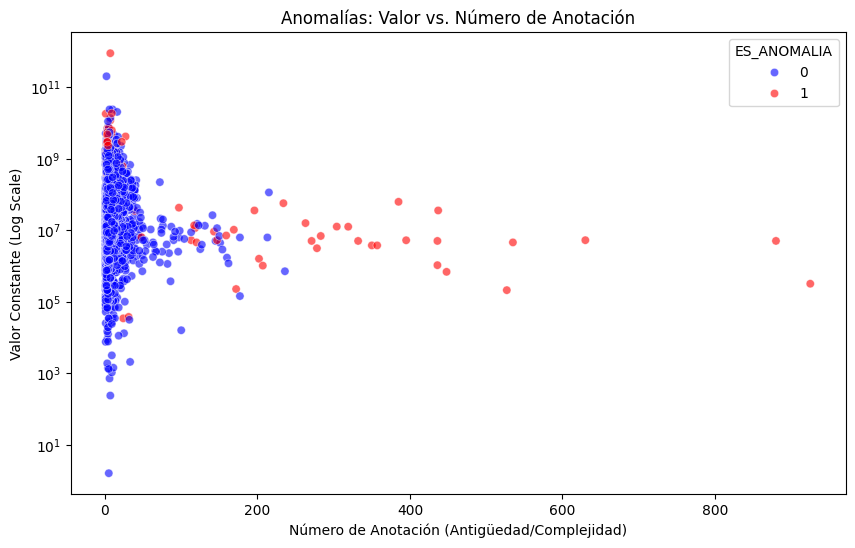

In [8]:
print("📊 Analizando Anomalías...")

# Separar normales y anomalías
anomalies = df_anom[df_anom['ES_ANOMALIA'] == 1]
normal = df_anom[df_anom['ES_ANOMALIA'] == 0]

# 1. Estadísticas de Valor
print("\n--- Comparación de VALOR CONSTANTE (Promedio) ---")
print(f"Normales:  ${normal['VALOR_CONSTANTE_2024'].mean():,.0f}")
print(f"Anomalías: ${anomalies['VALOR_CONSTANTE_2024'].mean():,.0f}")

# 2. Top Municipios con más anomalías
print("\n--- Top 5 Municipios con más Anomalías ---")
print(anomalies['MUNICIPIO'].value_counts().head(5))

# 3. Visualización (Scatter Plot)
# Usamos una muestra para no saturar la gráfica
sample = df_anom.sample(n=10000, random_state=42)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=sample, 
    x='NUM_ANOTACION', 
    y='VALOR_CONSTANTE_2024', 
    hue='ES_ANOMALIA', 
    palette={0: 'blue', 1: 'red'},
    alpha=0.6
)
plt.yscale('log')
plt.title("Anomalías: Valor vs. Número de Anotación")
plt.xlabel("Número de Anotación (Antigüedad/Complejidad)")
plt.ylabel("Valor Constante (Log Scale)")
plt.show()

## Guardar Resultados para Revisión

Guardamos este dataset enriquecido. Este será el insumo para tu Tablero de Monitoreo (OE4) y para la revisión manual o con NLP.

In [9]:
# Guardar resultado
ANOMALY_FILE = PROCESSED_DATA_DIR / "igac_anomalies_detected.parquet"
print(f"💾 Guardando resultados en: {ANOMALY_FILE}")

# Convertir de vuelta a Polars para guardar eficiente
pl.from_pandas(df_anom).write_parquet(ANOMALY_FILE)

print("✅ Proceso completado.")

💾 Guardando resultados en: c:\Users\carlo\Documents\KrozFu\repos\challenge-opendata\igac-anomalias-inmobiliarias\notebooks\..\data\processed\igac_anomalies_detected.parquet
✅ Proceso completado.


# Segunda Fase
##  Cargar las Anomalías Detectadas

In [10]:
import polars as pl
# Cargar el archivo que acabamos de guardar
df_anomalias = pl.read_parquet("../data/processed/igac_anomalies_detected.parquet")
# Filtrar solo las que son anomalía (1)
df_risk = df_anomalias.filter(pl.col("ES_ANOMALIA") == 1)
print(f"Analizando {df_risk.height} transacciones de alto riesgo...")

Analizando 57674 transacciones de alto riesgo...


## Reglas de Clasificación de Riesgo

Vamos a etiquetar automáticamente qué tipo de problema tienen.

In [11]:
print("🏷️ Etiquetando Tipos de Anomalía...")

df_risk = df_risk.with_columns(
    pl.when(pl.col("VALOR_CONSTANTE_2024") > 10_000_000_000) # Mayor a 10 mil millones
    .then(pl.lit("VALOR_EXTREMO"))
    .when(pl.col("VALOR_CONSTANTE_2024") < 1_000_000) # Menor a 1 millón (y no es 0)
    .then(pl.lit("VALOR_INFIMO"))
    .when(pl.col("NUM_ANOTACION") > 50)
    .then(pl.lit("TRAFICO_JURIDICO_INUSUAL"))
    .otherwise(pl.lit("OTRO_PATRON"))
    .alias("TIPO_ANOMALIA")
)

# Ver conteo por tipo
print(df_risk.group_by("TIPO_ANOMALIA").count().sort("count", descending=True))

🏷️ Etiquetando Tipos de Anomalía...
shape: (4, 2)
┌──────────────────────────┬───────┐
│ TIPO_ANOMALIA            ┆ count │
│ ---                      ┆ ---   │
│ str                      ┆ u32   │
╞══════════════════════════╪═══════╡
│ OTRO_PATRON              ┆ 31252 │
│ TRAFICO_JURIDICO_INUSUAL ┆ 19047 │
│ VALOR_INFIMO             ┆ 4140  │
│ VALOR_EXTREMO            ┆ 3235  │
└──────────────────────────┴───────┘


C:\Users\carlo\AppData\Local\Temp\ipykernel_23156\1218763524.py:15: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  print(df_risk.group_by("TIPO_ANOMALIA").count().sort("count", descending=True))


## Exportar para Tablero (Dashboard)

Esto cumple tu OE4 (Tablero de Monitoreo). Generaremos un archivo CSV listo para PowerBI/Tableau.

In [12]:
# Guardar CSV ligero para el Dashboard
dashboard_file = "../data/processed/tablero_riesgos.csv"
df_risk.write_csv(dashboard_file)
print(f"✅ Archivo para tablero generado: {dashboard_file}")

✅ Archivo para tablero generado: ../data/processed/tablero_riesgos.csv


## Diagrama de resultados

📊 Cargando datos del tablero...


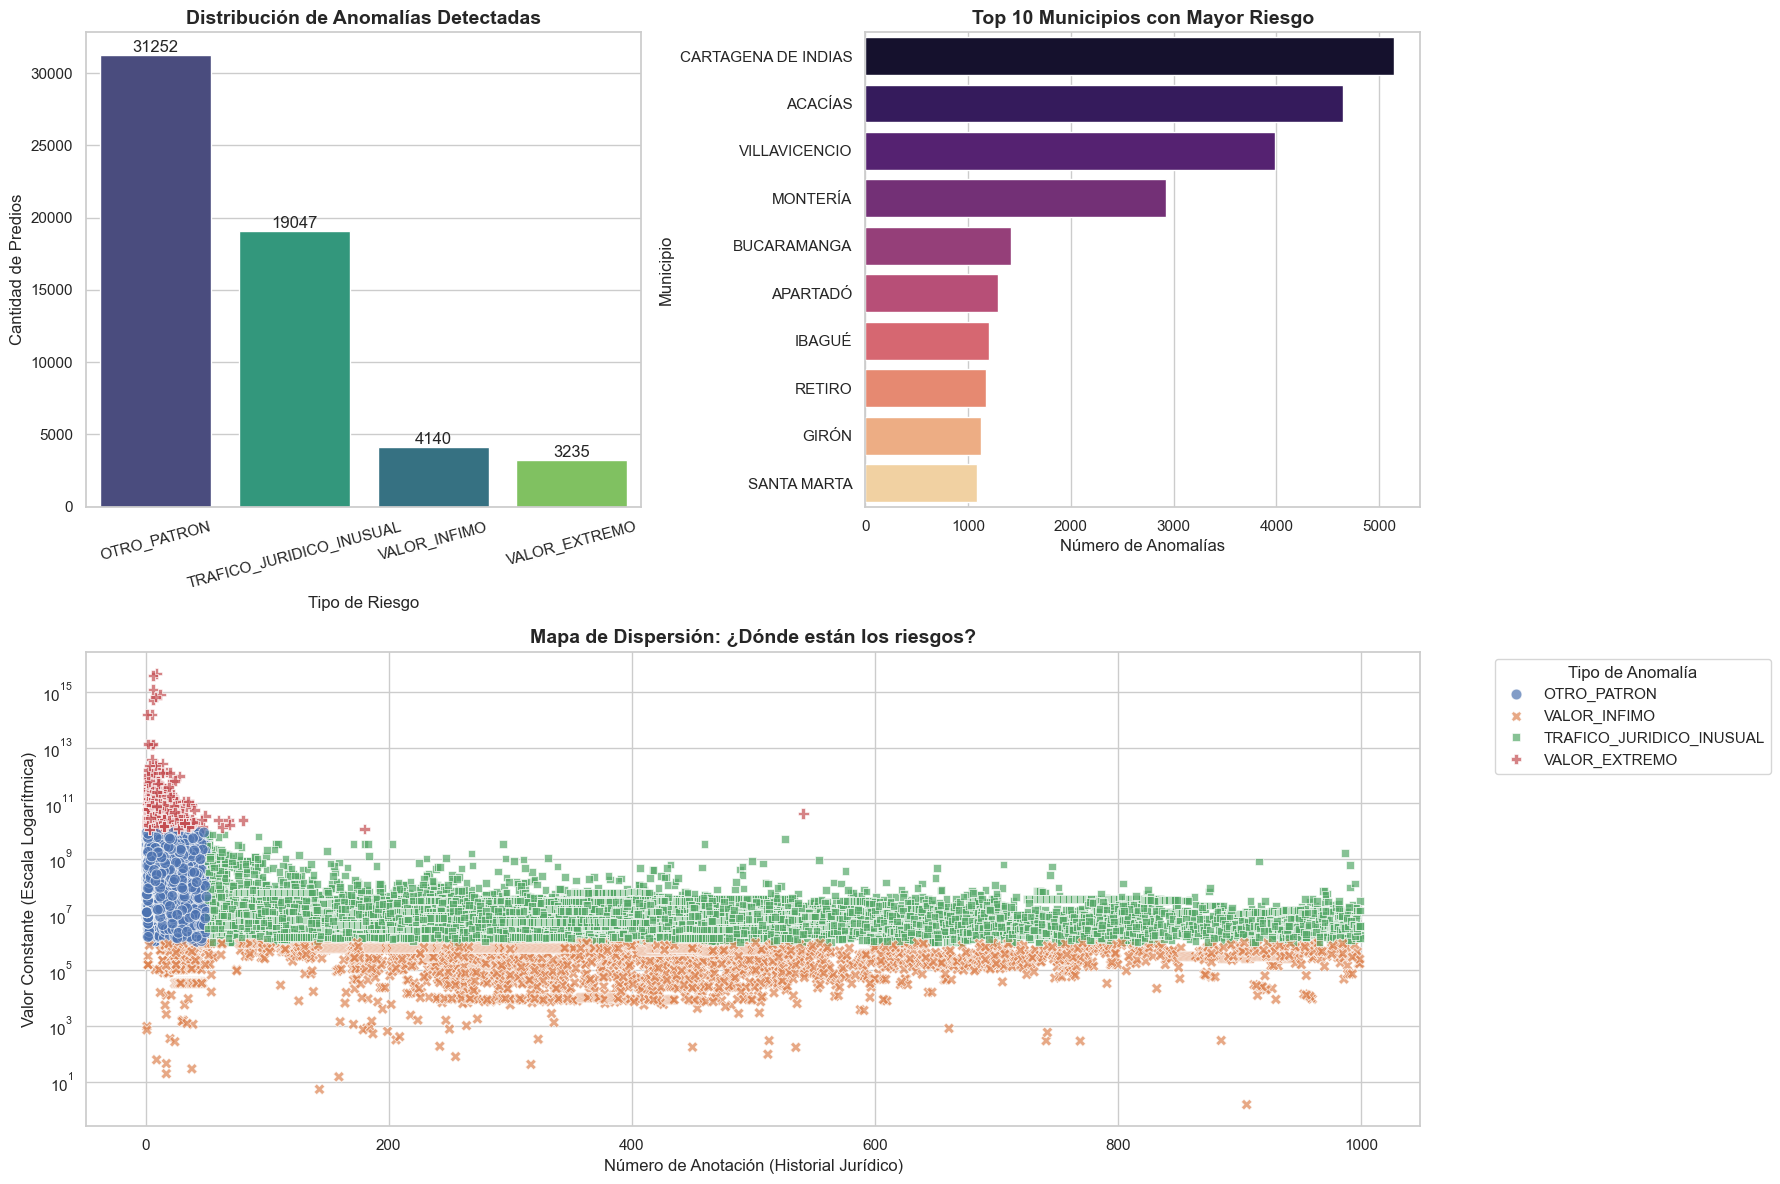

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Cargar el CSV generado
print("📊 Cargando datos del tablero...")
df_dashboard = pd.read_csv("../data/processed/tablero_riesgos.csv")

# Configuración de estilo
sns.set_theme(style="whitegrid")
plt.figure(figsize=(18, 12))

# --- GRÁFICO 1: Distribución de Tipos de Anomalía ---
plt.subplot(2, 2, 1)
# CORRECCIÓN: Asignamos 'x' a 'hue' y ponemos legend=False
ax1 = sns.countplot(
    data=df_dashboard,
    x="TIPO_ANOMALIA",
    hue="TIPO_ANOMALIA",  # <--- Cambio aquí
    palette="viridis",
    order=df_dashboard["TIPO_ANOMALIA"].value_counts().index,
    legend=False,  # <--- Cambio aquí
)
plt.title("Distribución de Anomalías Detectadas", fontsize=14, fontweight="bold")
plt.xlabel("Tipo de Riesgo")
plt.ylabel("Cantidad de Predios")
plt.xticks(rotation=15)
for container in ax1.containers:
    ax1.bar_label(container)

# --- GRÁFICO 2: Top 10 Municipios con Más Riesgo ---
plt.subplot(2, 2, 2)
top_municipios = df_dashboard["MUNICIPIO"].value_counts().head(10)
# CORRECCIÓN: Asignamos 'y' a 'hue' y ponemos legend=False
sns.barplot(
    x=top_municipios.values,
    y=top_municipios.index,
    hue=top_municipios.index,  # <--- Cambio aquí
    palette="magma",
    legend=False,  # <--- Cambio aquí
)
plt.title("Top 10 Municipios con Mayor Riesgo", fontsize=14, fontweight="bold")
plt.xlabel("Número de Anomalías")
plt.ylabel("Municipio")

# --- GRÁFICO 3: Dispersión Valor vs. Antigüedad ---
plt.subplot(2, 1, 2)
sns.scatterplot(
    data=df_dashboard,
    x="NUM_ANOTACION",
    y="VALOR_CONSTANTE_2024",
    hue="TIPO_ANOMALIA",
    style="TIPO_ANOMALIA",
    palette="deep",
    alpha=0.7,
    s=60,
)
plt.yscale("log")
plt.title(
    "Mapa de Dispersión: ¿Dónde están los riesgos?", fontsize=14, fontweight="bold"
)
plt.xlabel("Número de Anotación (Historial Jurídico)")
plt.ylabel("Valor Constante (Escala Logarítmica)")
plt.legend(title="Tipo de Anomalía", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

## Guardado

In [15]:
# Directorio de modelos (ya existe, pero por seguridad)
MODELS_DIR = DATA_DIR / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print(f"📂 Guardando detector de anomalías en: {MODELS_DIR}")

# 1. Guardar Modelo Isolation Forest
iso_path = MODELS_DIR / "isolation_forest_v1.pkl"
joblib.dump(iso_forest, iso_path)
print(f"💾 Modelo guardado: {iso_path}")

# 2. Guardar Artefactos de Anomalías (Scaler y Encoders específicos de este modelo)
# Importante: Este modelo usó un Scaler y Encoders diferentes a LightGBM
anom_artifacts = {
    "scaler": scaler,  # El StandardScaler que usaste
    "encoders": encoders,  # El diccionario de LabelEncoders de Depto/Muni
    "features": features_anomaly,  # La lista de columnas que espera recibir
}

anom_artifacts_path = MODELS_DIR / "anomalies_artifacts_v1.pkl"
joblib.dump(anom_artifacts, anom_artifacts_path)
print(f"💾 Artefactos de anomalías guardados: {anom_artifacts_path}")


📂 Guardando detector de anomalías en: c:\Users\carlo\Documents\KrozFu\repos\challenge-opendata\igac-anomalias-inmobiliarias\notebooks\..\data\models
💾 Modelo guardado: c:\Users\carlo\Documents\KrozFu\repos\challenge-opendata\igac-anomalias-inmobiliarias\notebooks\..\data\models\isolation_forest_v1.pkl
💾 Artefactos de anomalías guardados: c:\Users\carlo\Documents\KrozFu\repos\challenge-opendata\igac-anomalias-inmobiliarias\notebooks\..\data\models\anomalies_artifacts_v1.pkl
